In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='W', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44267 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:45518 Dashboard: http://127.0.0.1:44267/status,Cluster Workers: 24 Cores: 168 Memory: 810.56 GB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'

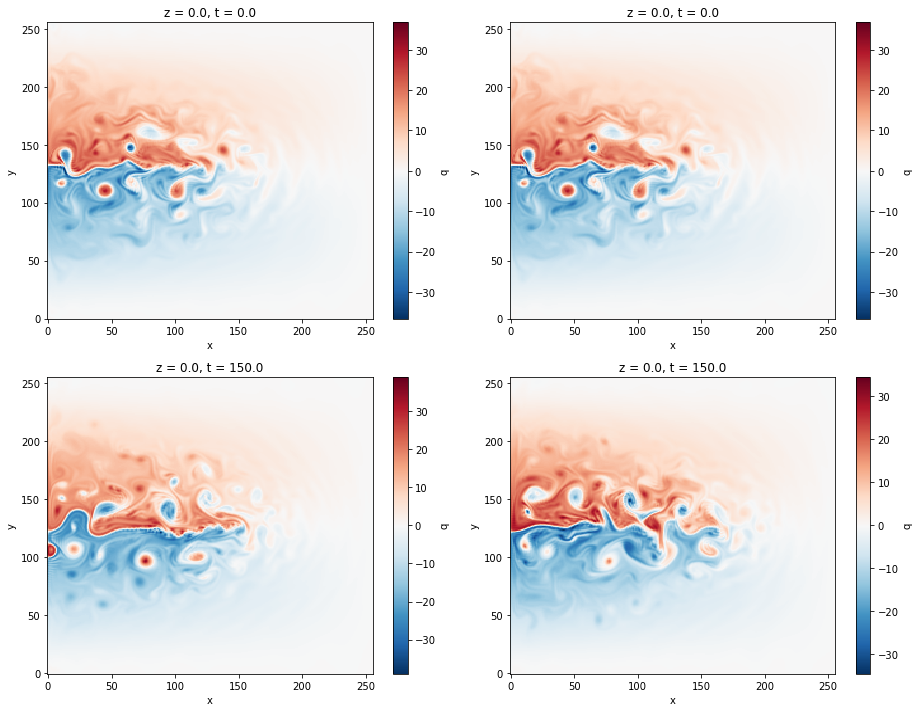

In [7]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

xr.open_dataset(op.join(ddir,'ctrl/vars000.nc')).q.isel(t=0,z=0).plot(ax=axes[0,0])
xr.open_dataset(op.join(ddir,'run50/vars000.nc')).q.isel(t=0,z=0).plot(ax=axes[0,1])
xr.open_dataset(op.join(ddir,'ctrl/vars000.nc')).q.isel(t=150,z=0).plot(ax=axes[1,0])
xr.open_dataset(op.join(ddir,'run50/vars000.nc')).q.isel(t=150,z=0).plot(ax=axes[1,1])

In [4]:
U = .1
T = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 1500.+63.
# f0 = 8e-5
beta = .5
N = 256    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = int(62.2*4)+1

percent = 20
nmemb = 75

In [5]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet'):
    
    nd = psi.ndim
    
    if nd==3:
        psi_padded = qgutils.pad_bc(psi.values, bc=bc)
    else:
        psi_padded = pad_bc(psi.values, bc=bc)

        
    lap = (psi_padded[...,2:,1:-1] + psi_padded[...,:-2,1:-1] 
           + psi_padded[...,1:-1,2:] + psi_padded[...,1:-1,:-2] 
           - 4*psi_padded[...,1:-1,1:-1]
          ) / Delta**2
#     lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
#            + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
#            + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
#            + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
#            - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
#           ) / Delta**2

    return xr.DataArray(lap, dims=psi.dims, coords=psi.coords).chunk(psi.chunks)

In [6]:
for i in range(0,nmemb+1):
    if i < nmemb:
        if i == 0:
#             ds = xr.open_zarr(op.join(ddir, 'run%03d/20percent/vars000_last187timesteps' % i)).isel(time=-1)
#             dsw = xr.open_zarr(op.join(ddir, 'run%03d/20percent/W000' % i)).isel(time=-1)
            ds = xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/vars000' % i)).isel(time=slice(-ntime,None))
            dsw = xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/W000' % i)).isel(time=slice(-ntime,None))
            dsp1 = xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/psi_padded' % i)).isel(time=slice(-ntime,None))
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/vars000' % i)
                                           ).isel(time=slice(-ntime,None))
                           ], 'nmemb')
            dsw = xr.concat([dsw,xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/W000' % i)
                                             ).isel(time=slice(-ntime,None))
                            ], 'nmemb')
            dsp1 = xr.concat([dsp1,xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/psi_padded' % i)
                                               ).isel(time=slice(-ntime,None))
                             ], 'nmemb')
    else:
        ds = xr.concat([ds,xr.open_zarr(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/vars000')
                                       ).isel(time=slice(-ntime,None))
                       ], 'nmemb')
        dsw = xr.concat([dsw,xr.open_zarr(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/W000')
                                         ).isel(time=slice(-ntime,None))
                        ], 'nmemb')
        dsp1 = xr.concat([dsp1,xr.open_zarr(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/psi_padded')
                                           ).isel(time=slice(-ntime,None))
                         ], 'nmemb')
        
ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
dsw.coords['nmemb'] = ('nmemb',range(nmemb+1))
dsp1.coords['nmemb'] = ('nmemb',range(nmemb+1))
ds = ds.chunk({'nmemb':6})
dsw = dsw.chunk({'nmemb':6})
dsp1 = dsp1.chunk({'nmemb':6})

grid = Grid(ds, periodic=[],
            coords={'Z':{'center':'Z','outer':'Zp1'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
gridz = Grid(ds.isel(Zp1=slice(1,-1)), periodic=[],
            coords={'Z':{'outer':'Z','center':'Zp1'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )

psib = ds.p.mean('nmemb')
psip = ds.p - psib
bb = -grid.diff(psib,'Z',boundary='extend') / ds.drC
bp = -grid.diff(psip,'Z',boundary='extend') / ds.drC
wb = dsw.w.mean('nmemb')
wp = dsw.w - wb

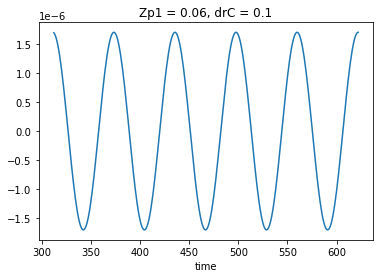

In [7]:
Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))})
aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))})
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
gp = Fr**-2 * ds.drC.isel(Zp1=slice(1,-1))
gpinv_t = (np.cos(2*np.pi*fFr_r**-1*ds.time) 
           * Frm**2 * ds.drC.isel(Zp1=slice(1,-1))**-1*aFrN*(2*np.pi*fFr_r**-1)
          )
gpinv_t.isel(Zp1=0).plot()

In [8]:
dpsib_z = -grid.diff(psib,'Z',boundary='extend').isel(Zp1=slice(1,-1))
dpsip_z = -grid.diff(psip,'Z',boundary='extend').isel(Zp1=slice(1,-1))
psi_padb = psi_padded.mean('nmemb')
psi_padp = psi_padded - psi_padb
ub = -psi_padb.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
up = -psi_padp.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
vb = psi_padb.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
vp = psi_padp.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
psip1_padb = psip1_padded.mean('nmemb')
psip1_padp = psip1_padded - psip1_padb
up1b = -psip1_padb.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
up1p = -psip1_padp.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
vp1b = psip1_padb.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
vp1p = psip1_padp.isel(Yp1=slice(1,-1)).diff('Xp1') / dx

In [9]:
psidagger = xr.DataArray((ds.p.isel(Z=slice(None,-1)).data 
                          * ds.drF.isel(Z=slice(1,None)).data[np.newaxis,:,np.newaxis,np.newaxis]
                          + ds.p.isel(Z=slice(1,None)).data 
                          * ds.drF.isel(Z=slice(None,-1)).data[np.newaxis,:,np.newaxis,np.newaxis]
                         ) / (ds.drF.isel(Z=slice(1,None)).data 
                              + ds.drF.isel(Z=slice(None,-1)).data)[np.newaxis,:,np.newaxis,np.newaxis],
                         dims=['nmemb','time','Zp1','YC','XC'],
                         coords={'nmemb':ds.nmemb.data,'time':ds.time.data,
                                 'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                                 'YC':ds.YC.data,'XC':ds.XC.data}
                        ).chunk({'nmemb':10,'time':6,'YC':128,'XC':128})

psidaggerb = psidagger.mean('nmemb')
psidaggerp = psidagger - psidaggerb
psidaggerp

,Array,Chunk
Bytes,24.78 GB,15.73 MB
Shape,"(76, 311, 2, 256, 256)","(10, 6, 2, 128, 128)"
Count,435787 Tasks,1664 Chunks
Type,float64,numpy.ndarray


In [10]:
K1_K2 = -Rom**-1 * (wb*psidaggerb).isel(Zp1=0).sum(['YC','XC']).compute() * dx**2
k1_k2 = -Rom**-1 * (wp*psidaggerp).isel(Zp1=0).mean('nmemb').sum(['YC','XC']).compute() * dx**2
K2_K3 = -Rom**-1 * (wb*psidaggerb).isel(Zp1=1).sum(['YC','XC']).compute() * dx**2
k2_k3 = -Rom**-1 * (wp*psidaggerp).isel(Zp1=1).mean('nmemb').sum(['YC','XC']).compute() * dx**2
# K1_K2

In [11]:
P1_K1 = (1/Rom * (wb * dpsib_z).isel(Zp1=0).sum(['YC','XC']).compute() * dx**2 
         * ds.drF.isel(Z=0)/ds.drF.isel(Z=slice(None,2)).sum('Z')).compute()

p1_k1 = (1/Rom * (wp * dpsip_z).isel(Zp1=0).mean('nmemb').sum(['YC','XC']).compute() * dx**2 
         * ds.drF.isel(Z=0)/ds.drF.isel(Z=slice(None,2)).sum('Z')).compute()
###################
P1_K2 = (1/Rom * (wb * dpsib_z).isel(Zp1=0).sum(['YC','XC']).compute() * dx**2 
         * ds.drF.isel(Z=1)/ds.drF.isel(Z=slice(None,2)).sum('Z')).compute()

p1_k2 = (1/Rom * (wp * dpsip_z).isel(Zp1=0).mean('nmemb').sum(['YC','XC']).compute() * dx**2 
         * ds.drF.isel(Z=1)/ds.drF.isel(Z=slice(None,2)).sum('Z')).compute()
###################
###################
P2_K2 = (1/Rom * (wb * dpsib_z).isel(Zp1=1).sum(['YC','XC']).compute() * dx**2 
         * ds.drF.isel(Z=1)/ds.drF.isel(Z=slice(1,None)).sum('Z')).compute()

p2_k2 = (1/Rom * (wp * dpsip_z).isel(Zp1=1).mean('nmemb').sum(['YC','XC']).compute() * dx**2 
         * ds.drF.isel(Z=1)/ds.drF.isel(Z=slice(1,None)).sum('Z')).compute()
###################
P2_K3 = (1/Rom * (wb * dpsib_z).isel(Zp1=1).sum(['YC','XC']).compute() * dx**2 
         * ds.drF.isel(Z=-1)/ds.drF.isel(Z=slice(1,None)).sum('Z')).compute()

p2_k3 = (1/Rom * (wp * dpsip_z).isel(Zp1=1).mean('nmemb').sum(['YC','XC']).compute() * dx**2 
         * ds.drF.isel(Z=-1)/ds.drF.isel(Z=slice(1,None)).sum('Z')).compute()
# print(P1_K1,P1_K2,P2_K2,P2_K3)

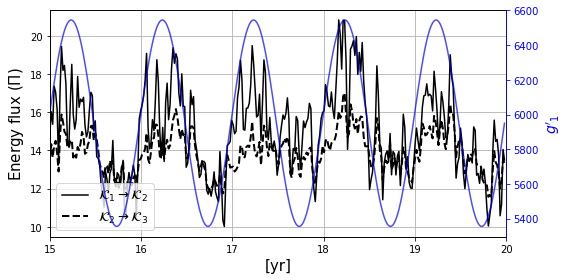

In [13]:
fig, ax1 = plt.subplots(figsize=(8,4), nrows=1, ncols=1)
fig.set_tight_layout(True)
ax2 = ax1.twinx()
# ax4 = ax3.twinx()


# ax1.plot(ds.time*T/(diny*86400)+1e1, K1_K2, 'k', lw=2,
#         label=r"$K^\#_1\rightarrow K^\#_2$")
ax1.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), k1_k2, 'k', 
         label=r"$\mathcal{K}_1\rightarrow \mathcal{K}_2$")
# ax1.plot(ds.time*T/(diny*86400)+1e1, K2_K3, 'r', lw=2, alpha=.8,
#         label=r"$K^\#_2\rightarrow K^\#_3$")
ax1.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), k2_k3, 'k--', lw=2,
         label=r"$\mathcal{K}_2\rightarrow \mathcal{K}_3$")

# ax3.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), p1_k1, 'r',
#         label=r"$\mathcal{P}_1\rightarrow \mathcal{K}_1$")
# ax3.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), p1_k2, 'r--', lw=2,
#         label=r"$\mathcal{P}_1\rightarrow \mathcal{K}_2$")
# ax3.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), p2_k2, 'r:', lw=2,
#         label=r"$\mathcal{P}_2\rightarrow \mathcal{K}_2$")
# ax3.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), p2_k3, 'r-.', lw=2,
#         label=r"$\mathcal{P}_2\rightarrow \mathcal{K}_3$")


ax2.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), gp.isel(Zp1=0), 'b', alpha=.7)
# ax4.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), gp.isel(Zp1=0), 'b', alpha=.7)

ax1.set_xlim([16.,20.])
# ax1.set_ylim([100.,900.])
ax1.legend(fontsize=13, loc='lower left')
ax1.grid(True)
ax1.set_xlabel(r"[yr]", fontsize=15)
ax1.set_ylabel(r"Energy flux ($\Pi$)", fontsize=15)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

# ax3.set_xlim([15.,20.])
# ax3.set_ylim([-3.,3.])
# ax3.legend(fontsize=13, loc='lower left')
# ax3.grid(True)
# ax3.set_ylabel(r"Energy flux ($\Pi$)", fontsize=15)
# ax4.set_ylabel(r"$g'_1$", fontsize=14, c='b')
# ax4.spines['right'].set_color('b')
# ax4.tick_params(axis='y', colors='b')

plt.savefig(op.join(ddir,'../Figs/eddyPis_interlayer.pdf'))

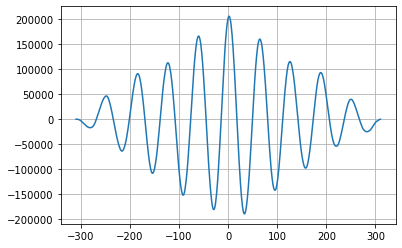

In [14]:
plt.plot(range(-ntime+1,ntime),np.correlate(k1_k2-k1_k2.mean(), gp.isel(Zp1=0)-gp.isel(Zp1=0).mean(), mode='full'))
plt.grid(True)

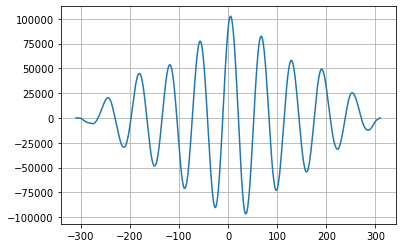

In [15]:
plt.plot(range(-ntime+1,ntime), np.correlate(k2_k3-k2_k3.mean(), gp.isel(Zp1=0)-gp.isel(Zp1=0).mean(), mode='full'))
plt.grid(True)

In [16]:
(np.argmax(np.correlate(k1_k2-k1_k2.mean(), gp.isel(Zp1=0)-gp.isel(Zp1=0).mean(), mode='full'))- (ntime - 1))*T/86400

11.574074074074074

In [17]:
(np.argmax(np.correlate(k2_k3-k2_k3.mean(), gp.isel(Zp1=0)-gp.isel(Zp1=0).mean(), mode='full'))- (ntime - 1))*T/86400

28.935185185185187

In [18]:
(np.argmin(np.correlate(p1_k2-p1_k2.mean(), gp.isel(Zp1=0)-gp.isel(Zp1=0).mean(), mode='full'))- (ntime - 1))*T/86400

-5.787037037037037

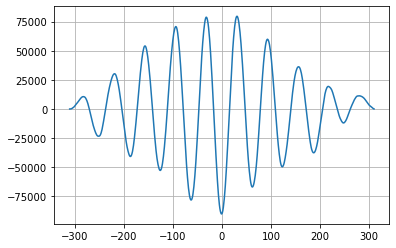

In [20]:
plt.plot(range(-ntime+1,ntime), np.correlate(p1_k2-p1_k2.mean(), gp.isel(Zp1=0)-gp.isel(Zp1=0).mean(), mode='full'))
plt.grid(True)

In [21]:
(np.argmin(np.correlate(p2_k2-p2_k2.mean(), gp.isel(Zp1=0)-gp.isel(Zp1=0).mean(), mode='full'))- (ntime - 1))*T/86400

-11.574074074074074

In [22]:
(np.argmin(np.correlate(p2_k3-p2_k3.mean(), gp.isel(Zp1=0)-gp.isel(Zp1=0).mean(), mode='full'))- (ntime - 1))*T/86400

-11.574074074074074

In [7]:
K1_k1 = (psib * (grid.interp(grid.diff(grid.interp(up,'Y',boundary='fill') * lapsip,
                                       'X',boundary='fill'),
                             'X',boundary='fill')
                 + grid.interp(grid.diff(grid.interp(vp,'X',boundary='fill') * lapsip,
                                         'Y',boundary='fill'),
                               'Y',boundary='fill')
                ).mean('nmemb') / dx * ds.drF * dx**2
        ).isel(Z=0).sum(['YC','XC']).compute()
print(K1_k1)

NameError: name 'dpsib_z' is not defined

In [ ]:
K2_K1 = (1/Rom * (wb * psidaggerb).isel(Zp1=0)).sum(['YC','XC']).compute() * dx**2
k2_k1 = (1/Rom * (wp * psidaggerp).isel(Zp1=0).mean('nmemb')).sum(['YC','XC']).compute() * dx**2
K3_K2 = (1/Rom * (wb * psidaggerb).isel(Zp1=1)).sum(['YC','XC']).compute() * dx**2
k3_k2 = (1/Rom * (wp * psidaggerp).isel(Zp1=1).mean('nmemb')).sum(['YC','XC']).compute() * dx**2

In [10]:
P_p1 = -((dpsib_z.isel(Zp1=0) * (grid.interp(grid.diff(grid.interp(up.isel(Z=0),'Y',boundary='fill').data
                                                       * dpsip_z.isel(Zp1=0),'X',boundary='fill'),
                                             'X',boundary='fill')
                                 + grid.interp(grid.diff(grid.interp(vp.isel(Z=0),'X',boundary='fill').data
                                                         * dpsip_z.isel(Zp1=0),'Y',boundary='fill'),
                                               'Y',boundary='fill')
                                ).mean('nmemb').data / dx
        ) * dx**2 / gp.isel(Zp1=0)).sum(['XC','YC']) / Rom**2
P_p3 = -((dpsib_z.isel(Zp1=-1) * (grid.interp(grid.diff(grid.interp(up.isel(Z=-1),'Y',boundary='fill').data
                                                        * dpsip_z.isel(Zp1=-1),'X',boundary='fill'),
                                              'X',boundary='fill')
                                  + grid.interp(grid.diff(grid.interp(vp.isel(Z=-1),'X',boundary='fill').data
                                                          * dpsip_z.isel(Zp1=-1),'Y',boundary='fill'),
                                                'Y',boundary='fill')
                                 ).mean('nmemb').data / dx
        ) * dx**2 / gp.isel(Zp1=-1)).sum(['XC','YC']) / Rom**2

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.DataArray (time: 187)>
array([17.75252572, 19.28689653, 20.28741266, 20.5692748 , 21.75448824,
       21.26217542, 20.31924614, 20.68570547, 17.76244863, 18.10918406,
       24.27018037, 25.20394074, 21.12718701, 15.34624633, 13.16236905,
       14.89090633, 14.69392333, 16.95694034, 17.55670996, 16.48203527,
       18.27591693, 18.40251198, 17.93368144, 21.92037792, 24.54189531,
       23.73770604, 20.12595239, 18.43500049, 17.30944971, 17.07493815,
       15.92302287, 17.6465475 , 17.18609793, 17.41555411, 16.36022426,
       17.69375395, 20.32243427, 21.24760175, 19.60931999, 18.77208043,
       22.84793765, 22.88914216, 18.204391  , 15.74038504, 14.1451533 ,
       15.03826122, 15.92951954, 15.60857906, 15.17552769, 17.11286073,
       19.48381678, 21.47152399, 20.86813139, 18.88836206, 15.39655601,
       16.3593416 , 16.74413464, 14.69727682, 14.05360764, 15.38949851,
       17.00363871, 16.63768226, 17.54616804, 17.34101569, 18.34703149,
       18.49875906, 22.48378099, 27.01773586, 26.81960036, 22.68853888,
       20.51754336, 21.1562785 , 21.6202876 , 21.75043022, 24.51915634,
       26.71351271, 24.44622461, 21.6151789 , 21.36632417, 21.72553579,
       23.79361605, 27.5161429 , 27.44604954, 22.36996962, 18.68549691,
       16.61276308, 16.90246117, 20.43883292, 21.89514079, 20.2517011 ,
       20.9674594 , 20.28155015, 18.11122018, 18.14056453, 18.80526472,
       20.36617663, 21.59677367, 19.9694598 , 17.91216683, 16.14589292,
       18.74260492, 23.52446848, 25.22678316, 21.62885138, 21.63449015,
       20.28921969, 19.74314387, 19.61358645, 19.93826099, 19.70094143,
       19.29655091, 19.02023455, 18.90510915, 19.18605711, 17.43044622,
       14.15299354, 11.5347281 , 13.51623342, 14.66880299, 16.30177735,
       17.76461969, 17.57177066, 15.89067725, 16.02118097, 18.37956739,
       19.32849745, 20.94006596, 20.46205531, 21.26904106, 23.40955856,
       26.18739837, 25.63592836, 23.79951974, 22.49760054, 21.67841616,
       19.42378422, 19.96981898, 19.22892291, 19.76830762, 15.72103848,
       10.06063016, 11.05137955, 18.40148695, 23.49536363, 24.78885887,
       24.07839404, 22.1110628 , 24.07795646, 26.50896384, 26.9743497 ,
       28.63127246, 24.90570043, 19.71342736, 17.63161   , 21.23171337,
       25.04029938, 27.20524287, 26.51484284, 24.6847579 , 23.61493167,
       22.16856013, 18.16349515, 15.35035001, 13.65094957, 16.25396919,
       22.08317673, 23.03369233, 24.05923291, 22.27006876, 18.49363498,
       14.35466579, 13.19028595, 14.67470359, 17.94116416, 18.70860444,
       21.52392445, 22.95770904, 19.28852278, 15.58657572, 15.19068577,
       16.64119343, 17.62221109, 13.97924225, 12.80557971, 16.30332508,
       18.00259085, 19.88825132])
Coordinates:
  * time     (time) float32 435.0 436.0 437.0 438.0 ... 618.0 619.0 620.0 621.0

In [15]:
B_P = -.5*Rom**-2 * (dpsib_z.isel(Zp1=0)**2 * gpinv_t.isel(Zp1=0)
                    ).sum(['XC','YC']).compute() * dx**2
B_p = -.5*Rom**-2 * ((dpsip_z.isel(Zp1=0)**2).mean('nmemb') * gpinv_t.isel(Zp1=0)
                    ).sum(['XC','YC']).compute() * dx**2
B_p

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.DataArray (time: 187)>
array([-17.72361365, -18.34764804, -18.73676305, -18.91794354,
       -18.8862067 , -18.69252871, -18.26001985, -17.54263818,
       -16.55849394, -15.30928922, -13.73708104, -11.89539318,
        -9.80674264,  -7.54095905,  -5.12200789,  -2.543641  ,
         0.13538428,   2.86410954,   5.59113936,   8.26551199,
        10.82742856,  13.21182326,  15.38425443,  17.26808388,
        18.73285524,  19.88429079,  20.79736837,  21.42094914,
        21.79074452,  21.8394817 ,  21.62236871,  21.20527679,
        20.53609267,  19.69422249,  18.59011175,  17.32585444,
        15.96532616,  14.49202549,  12.98340266,  11.48959876,
         9.99016217,   8.49665203,   7.03440728,   5.59693359,
         4.18289147,   2.78584285,   1.40825672,   0.06626608,
        -1.24825602,  -2.54722164,  -3.83781995,  -5.13404431,
        -6.42272117,  -7.69963445,  -8.98934248, -10.29028521,
       -11.57946878, -12.84004321, -14.04895051, -15.17359158,
       -16.2235458 , -17.1578582 , -17.93100486, -18.46607172,
       -18.8485437 , -19.13146881, -19.1372782 , -18.8481922 ,
       -18.38435858, -17.74706027, -16.886736  , -15.7185338 ,
       -14.26151495, -12.50833424, -10.50437866,  -8.22119261,
        -5.72481786,  -3.09814352,  -0.40788496,   2.33012361,
...
         1.64859952,   0.32607128,  -0.97341631,  -2.25929102,
        -3.53637657,  -4.81587131,  -6.08342142,  -7.35183841,
        -8.62373751,  -9.87948359, -11.12766685, -12.36276012,
       -13.52554089, -14.6538986 , -15.70385031, -16.67451642,
       -17.57393633, -18.30299477, -18.77250645, -19.02159934,
       -19.10512417, -18.94223902, -18.50693112, -17.87985537,
       -16.9747691 , -15.75849401, -14.22879561, -12.47582323,
       -10.51774465,  -8.36114766,  -6.0132054 ,  -3.5086131 ,
        -0.92285736,   1.73402291,   4.41846533,   7.07284463,
         9.65026994,  12.08175969,  14.26021174,  16.20607397,
        17.8812665 ,  19.29458579,  20.45267636,  21.2372127 ,
        21.74210903,  21.95543338,  21.85478176,  21.44409979,
        20.74619802,  19.77965402,  18.62788351,  17.42415082,
        16.14000939,  14.79838637,  13.39565982,  11.9291503 ,
        10.46211706,   8.96189057,   7.46496107,   6.00084873,
         4.58693384,   3.21602629,   1.88917584,   0.58284785,
        -0.70875791,  -1.98281591,  -3.24551103,  -4.51356466,
        -5.76520679,  -6.99752539,  -8.22896832,  -9.42785188,
       -10.61718795, -11.75261333, -12.83865413, -13.90636571,
       -14.8918396 , -15.77649807, -16.56557997])
Coordinates:
  * time     (time) float32 435.0 436.0 437.0 438.0 ... 618.0 619.0 620.0 621.0
    Zp1      float64 0.06
    drC      float64 0.1

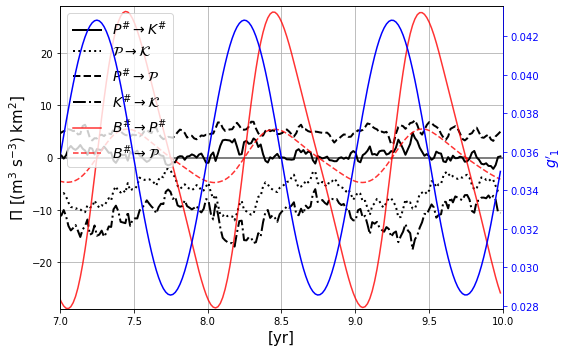

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(np.linspace(7,10,5), np.zeros(5), c='gray',
        lw=2)

ax.plot(ds.time*tau/(diny*86400), P_K*U**3/Rd*H*Rd**2 * 1e-6, 'k', lw=2,
        label=r"$P^\# \rightarrow K^\#$")
ax.plot(ds.time*tau/(diny*86400), p_k*U**3/Rd*H*Rd**2 * 1e-6, 'k:', lw=2,
        label=r"$\mathcal{P} \rightarrow \mathcal{K}$")
ax.plot(ds.time*tau/(diny*86400), P_p*U**3/Rd*H*Rd**2 * 1e-6, 'k--', lw=2,
        label=r"$P^\# \rightarrow \mathcal{P}$")
ax.plot(ds.time*tau/(diny*86400), K_k*U**3/Rd*H*Rd**2 * 1e-6, 'k-.', lw=2,
        label=r"$K^\# \rightarrow \mathcal{K}$")

ax.plot(ds.time*tau/(diny*86400), B_P*U**3/Rd*H*Rd**2 * 1e-6, c='r', alpha=.8,
        label=r"$B^\# \rightarrow P^\#$")
ax.plot(ds.time*tau/(diny*86400), B_p*U**3/Rd*H*Rd**2 * 1e-6, c='r', ls='--', alpha=.8, 
        label=r"$B^\# \rightarrow \mathcal{P}$")

ax2.plot(ds.time*tau/(diny*86400), gp.isel(Zp1=0)*U**2/H, 'b')

ax.set_xlim([7.,10.])
ax.set_ylim([-29.,29.])
ax.legend(fontsize=14, loc='upper left')
ax.set_ylabel(r"$\Pi$ [(m$^3$ s$^{-3}$) km$^2$]", fontsize=15)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.set_xlabel(r"[yr]", fontsize=15)
ax.grid(True)

plt.savefig(op.join(ddir,'../Figs/Pis_total.pdf'))

In [23]:
client.close()

In [6]:
62.2*5-16

295.0